In [1]:
# 기본 패키지
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import json

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
## 이미지에서 한글이 나오게 하는 설정
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

## 야후 파이낸스 패키지 ## pip install yfinance
import yfinance as yf

## 연준 패키지 ## pip install fredapi
from fredapi import Fred
## fred = Fred(api_key='Your API Key')

fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [2]:
## 사전 정의한 함수 모음
import graphModule as gm
import myfuncs as mf
from quant_functions import anal_funcs
import baseloader
import portfolio_obtimizer

In [3]:
## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

## Dataload

In [4]:
ticker = 'QLD'

In [5]:
df_ori = yf.download(ticker, ignore_tz = True, auto_adjust=True)
df_ori.columns = [x[0] for x in df_ori.columns]
## df_ori = df_ori.reset_index()

[*********************100%***********************]  1 of 1 completed


In [60]:
def calculate_CMO(price_series, period=14):
    """Chande Momentum Oscillator (CMO) 계산"""
    delta = price_series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta <= 0, -delta, 0)

    sum_gain = pd.Series(gain).rolling(window=period).sum()
    sum_loss = pd.Series(loss).rolling(window=period).sum()

    CMO = (sum_gain - sum_loss) / (sum_gain + sum_loss)
    CMO =  CMO[period:].fillna(0)
    CMO.index = price_series.index[period:]
    return CMO

def calculate_VVIDYA(price_series, volume_series, period=14, alpha_factor=0.2):
    """
    VVIDYA (Volumatic Variable Index Dynamic Average) 계산
    - price_series: 종가 데이터 (Series)
    - volume_series: 거래량 데이터 (Series)
    - period: CMO 및 이동 평균 계산 기간
    - alpha_factor: 가중치 스케일링 계수 (기본 0.2)
    """
    CMO = calculate_CMO(price_series, period)
    normalized_volume = volume_series / volume_series.rolling(period).mean()
    normalized_volume = normalized_volume[period:]  # CMO 계산 (첫 14일은 NaN)

    # CMO와 거래량을 반영한 가변 알파(alpha) 계산
    alpha = alpha_factor * np.abs(CMO) * normalized_volume
    ## alpha = alpha_factor * np.abs(CMO)
    alpha = alpha.clip(lower=0.01, upper=0.99)  # 너무 작은 값 방지

    # VVIDYA 초기화
    VVIDYA = np.zeros_like(alpha)
    VVIDYA[0] = price_series[period:].iloc[0]  # 첫 값 초기화

    # 적응형 EMA 적용
    for i in range(1, len(alpha)):
        VVIDYA[i] = VVIDYA[i - 1] + alpha.iloc[i] * (price_series.iloc[i] - VVIDYA[i - 1])

    return pd.Series(VVIDYA, index=alpha.index), normalized_volume  # CMO 계산 (첫 14일은 NaN)

In [61]:
srs, normalized_volume = calculate_VVIDYA(df_ori['Close'], df_ori['Volume'], period=14, alpha_factor=0.2)

In [59]:
srs * normalized_volume

Date
2006-07-12      3.169302
2006-07-13      5.239069
2006-07-14      2.522418
2006-07-17      1.727488
2006-07-18      4.021002
                 ...    
2025-03-17    337.246729
2025-03-18     51.626839
2025-03-19     73.551805
2025-03-20     62.482081
2025-03-21     72.018241
Length: 4704, dtype: float64

In [43]:
def chande_momentum_oscillator(close, period=14):
    """Chande Momentum Oscillator (CMO) 계산"""
    diff = close.diff(1)
    up = np.where(diff > 0, diff, 0)
    down = np.where(diff < 0, -diff, 0)
    sum_up = pd.Series(up).rolling(window=period).sum()
    sum_down = pd.Series(down).rolling(window=period).sum()
    cmo = 100 * (sum_up - sum_down) / (sum_up + sum_down)
    return cmo

def calc_vidya(close, cmo, period=14):
    close = close[period:]  # CMO 계산 (첫 14일은 NaN)
    cmo = cmo[period:]  # CMO 계산 (첫 14일은 NaN)
    """평활 계수를 반영한 VIDYA 계산"""
    vidya_values = [close.iloc[0]]  # 첫 번째 값 초기화
    alpha = 2 / (period + 1)  # 평활 계수

    for i in range(1, len(close)):
        dynamic_alpha = alpha * abs(cmo.iloc[i] / 100)  # CMO를 이용한 동적 평활 계수
        current_vidya = vidya_values[-1] + dynamic_alpha * (close.iloc[i] - vidya_values[-1])
        vidya_values.append(current_vidya)
        
    return pd.Series(vidya_values, index=close.index)

def calc_volumetric_vidya(close, volume, cmo, base_vidya, period=14):
    close = close[period:]  # CMO 계산 (첫 14일은 NaN)
    cmo = cmo[period:]  # CMO 계산 (첫 14일은 NaN)
    """Volumetric VIDYA 계산 (평활 계수 반영)"""
    avg_volume = volume.rolling(window=period).mean()[period:]
    nomalized_volume = volume / avg_volume
    volumetric_vidya = base_vidya * nomalized_volume
    return volumetric_vidya

In [44]:
cmo = chande_momentum_oscillator(df_ori['Close'])
vidya = calc_vidya(df_ori['Close'], cmo)
vvidya = calc_volumetric_vidya(df_ori['Close'], df_ori['Volume'], cmo, vidya)

<Axes: xlabel='Date'>

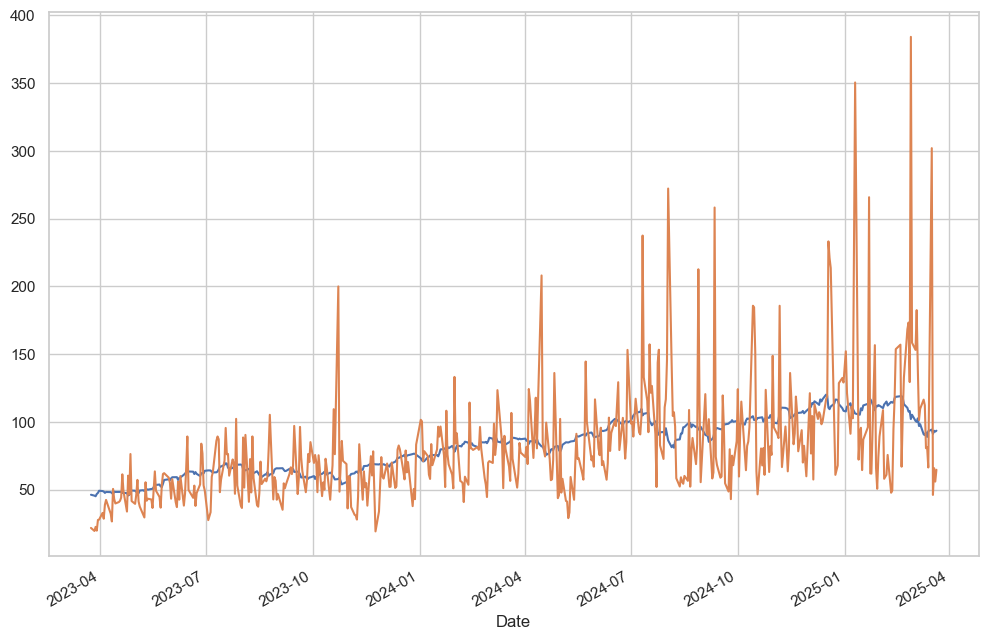

In [36]:
df_ori['Close'].tail(500).plot()
## vidya.tail(500).plot()
vvidya.tail(500).plot()

<Axes: xlabel='Date'>

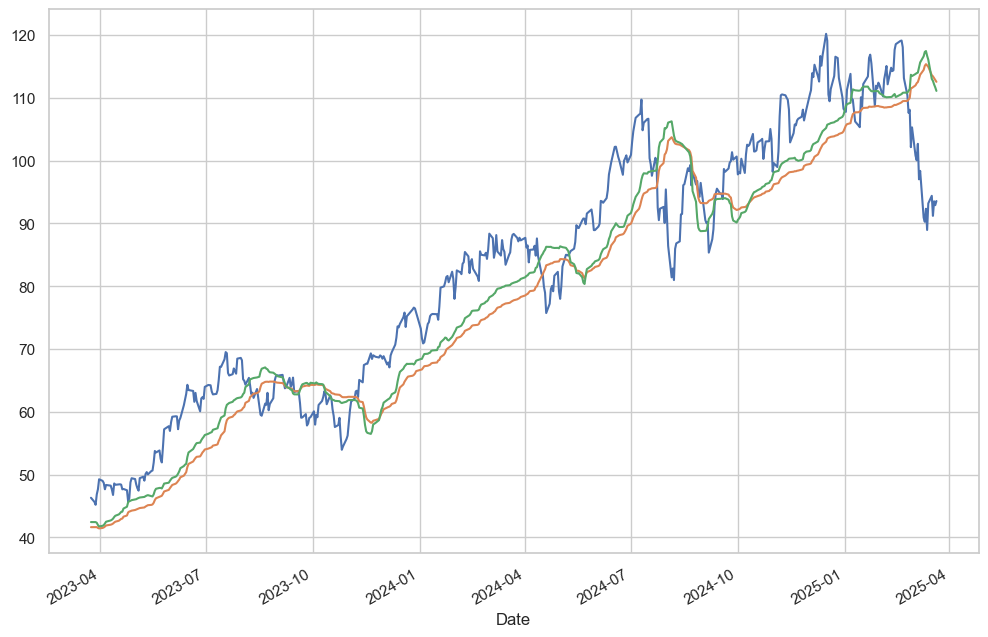

In [18]:
df_ori['Close'].tail(500).plot()
vvidya_values_up.tail(500).plot()
vvidya_values_down.tail(500).plot()

In [169]:
VVIDYA

array([  1.78800452,   1.81434673,   1.82495074, ..., 113.60747562,
       113.42388638, 113.12769195])

In [161]:
VVIDYA

array([  1.78800452,   1.81434673,   1.82495074, ..., 113.60747562,
       113.42388638, 113.12769195])

In [118]:
VVIDYA

array([1.97106135,        nan,        nan, ..., 0.        , 0.        ,
       0.        ])

In [120]:
alpha

Date
2006-07-12   NaN
2006-07-13   NaN
2006-07-14   NaN
2006-07-17   NaN
2006-07-18   NaN
              ..
2025-03-13   NaN
2025-03-14   NaN
2025-03-17   NaN
2025-03-18   NaN
2025-03-19   NaN
Length: 4702, dtype: float64

In [95]:

normalized_volume = volume_series / volume_series.rolling(period).mean()
normalized_volume = normalized_volume[period:]  # CMO 계산 (첫 14일은 NaN)

# CMO와 거래량을 반영한 가변 알파(alpha) 계산
alpha = alpha_factor * np.abs(CMO) * normalized_volume
alpha = alpha.clip(lower=0.01, upper=0.99)  # 너무 작은 값 방지

# VVIDYA 초기화
VVIDYA = np.zeros_like(price_series)
VVIDYA[0] = price_series.iloc[0]  # 첫 값 초기화

# 적응형 EMA 적용
for i in range(1, len(price_series)):
    VVIDYA[i] = VVIDYA[i - 1] + alpha.iloc[i] * (price_series.iloc[i] - VVIDYA[i - 1])

IndexError: single positional indexer is out-of-bounds

In [91]:
CMO

14     -0.318161
15     -0.330541
16     -0.362871
17     -0.360460
18     -0.253939
          ...   
4711   -0.555454
4712   -0.382157
4713   -0.304188
4714   -0.366118
4715   -0.202728
Length: 4702, dtype: float64

In [60]:
# VVIDYA 초기화
VVIDYA = np.zeros_like(price_series)
VVIDYA[0] = price_series.iloc[0]  # 첫 값 초기화

In [64]:
normalized_volume

Date
2006-06-21         NaN
2006-06-22         NaN
2006-06-23         NaN
2006-06-26         NaN
2006-06-27         NaN
                ...   
2025-03-13    0.792019
2025-03-14    0.649417
2025-03-17    2.962878
2025-03-18    0.455243
2025-03-19    0.647402
Name: Volume, Length: 4716, dtype: float64

In [62]:
alpha.iloc[i]

nan

In [56]:
VVIDYA[i - 1] + alpha.iloc[i] * (price_series.iloc[i] - VVIDYA[i - 1])

array([1.97106135,        nan,        nan, ...,        nan,        nan,
              nan])